# Analysis of exploratory behaviour aligned to onset

## Similarity between noise and signal correlation matrix evolution for all mice

''' Created on Thrus 6 May 2021'''


In this notebook we will analyze periods of ethogram exploration as classifyed with DLC. 

First we will extract the pre and post onset signal, aligned to the time when the events start. We will compute a mean population vector in the vecinity of the onset, and then analyze the full data by computing the signal correlation matrix and the noise correlation matrix in a day by day basis. 

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import scipy
cmap = cm.jet
import math

In [2]:
mouse_vector = [32363, 32364, 32365,56165]
conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
sessions_random = [1,0,2,0]
sessions_overlapping = [2,1,0,1]
sessions_stable = [0,2,0,0]
fixed_object_id = [6,4,0,5]


sessions = [sessions_random, sessions_overlapping, sessions_stable]
colapse = [0,1,2]

decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 3           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 0        ## registration version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
period = int(1 * sf / re_sf)
period_resting = period *10

In [3]:
file_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/cosine_similarity/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'


In [4]:
evolution_signal = []   
evolution_noise = []

for session_type in range(len(sessions)):
    session_numbers = sessions[session_type]
    colapse_behaviour = colapse[session_type]
    evolution_signal_type = []
    evolution_noise_type = []
    for mouse_number in range(len(mouse_vector)):
        mouse = mouse_vector[mouse_number]
        session = session_numbers[mouse_number]
        if session != 0:
            file_name1 = file_path + 'signal_cos_sim_evol_mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_binsize_10_period_3.npy'
            file_name2 = file_path + 'noise_cos_sim_evol_mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_binsize_10_period_3.npy'
            evolution_signal_type.append(np.load(file_name1))
            evolution_noise_type.append(np.load(file_name2))
    evolution_signal.append(evolution_signal_type)
    evolution_noise.append(evolution_noise_type)

In [5]:
print(evolution_signal[2])

[array([[0.07753629, 0.04535762, 0.07471706, 0.04321322, 0.1755447 ,
        0.06176824, 0.07512808, 0.24783425, 0.28014543, 0.24555577,
        0.12802342, 0.04857958, 0.13332583],
       [0.03918506, 0.05848505, 0.07934532, 0.09780319, 0.09603949,
        0.11343913, 0.02755631, 0.05641538, 0.06356372, 0.07700037,
        0.06926999, 0.05646742, 0.04804619],
       [0.09014735, 0.06008939, 0.04930376, 0.0500481 , 0.0827527 ,
        0.08180406, 0.0775841 , 0.10597776, 0.1398241 , 0.12048235,
        0.09207387, 0.10241354, 0.09435531],
       [0.02742592, 0.02967294, 0.02778918, 0.03920803, 0.11525381,
        0.01945393, 0.03898338, 0.07950296, 0.06225212, 0.04476999,
        0.03507149, 0.05510953, 0.02145917]])]


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


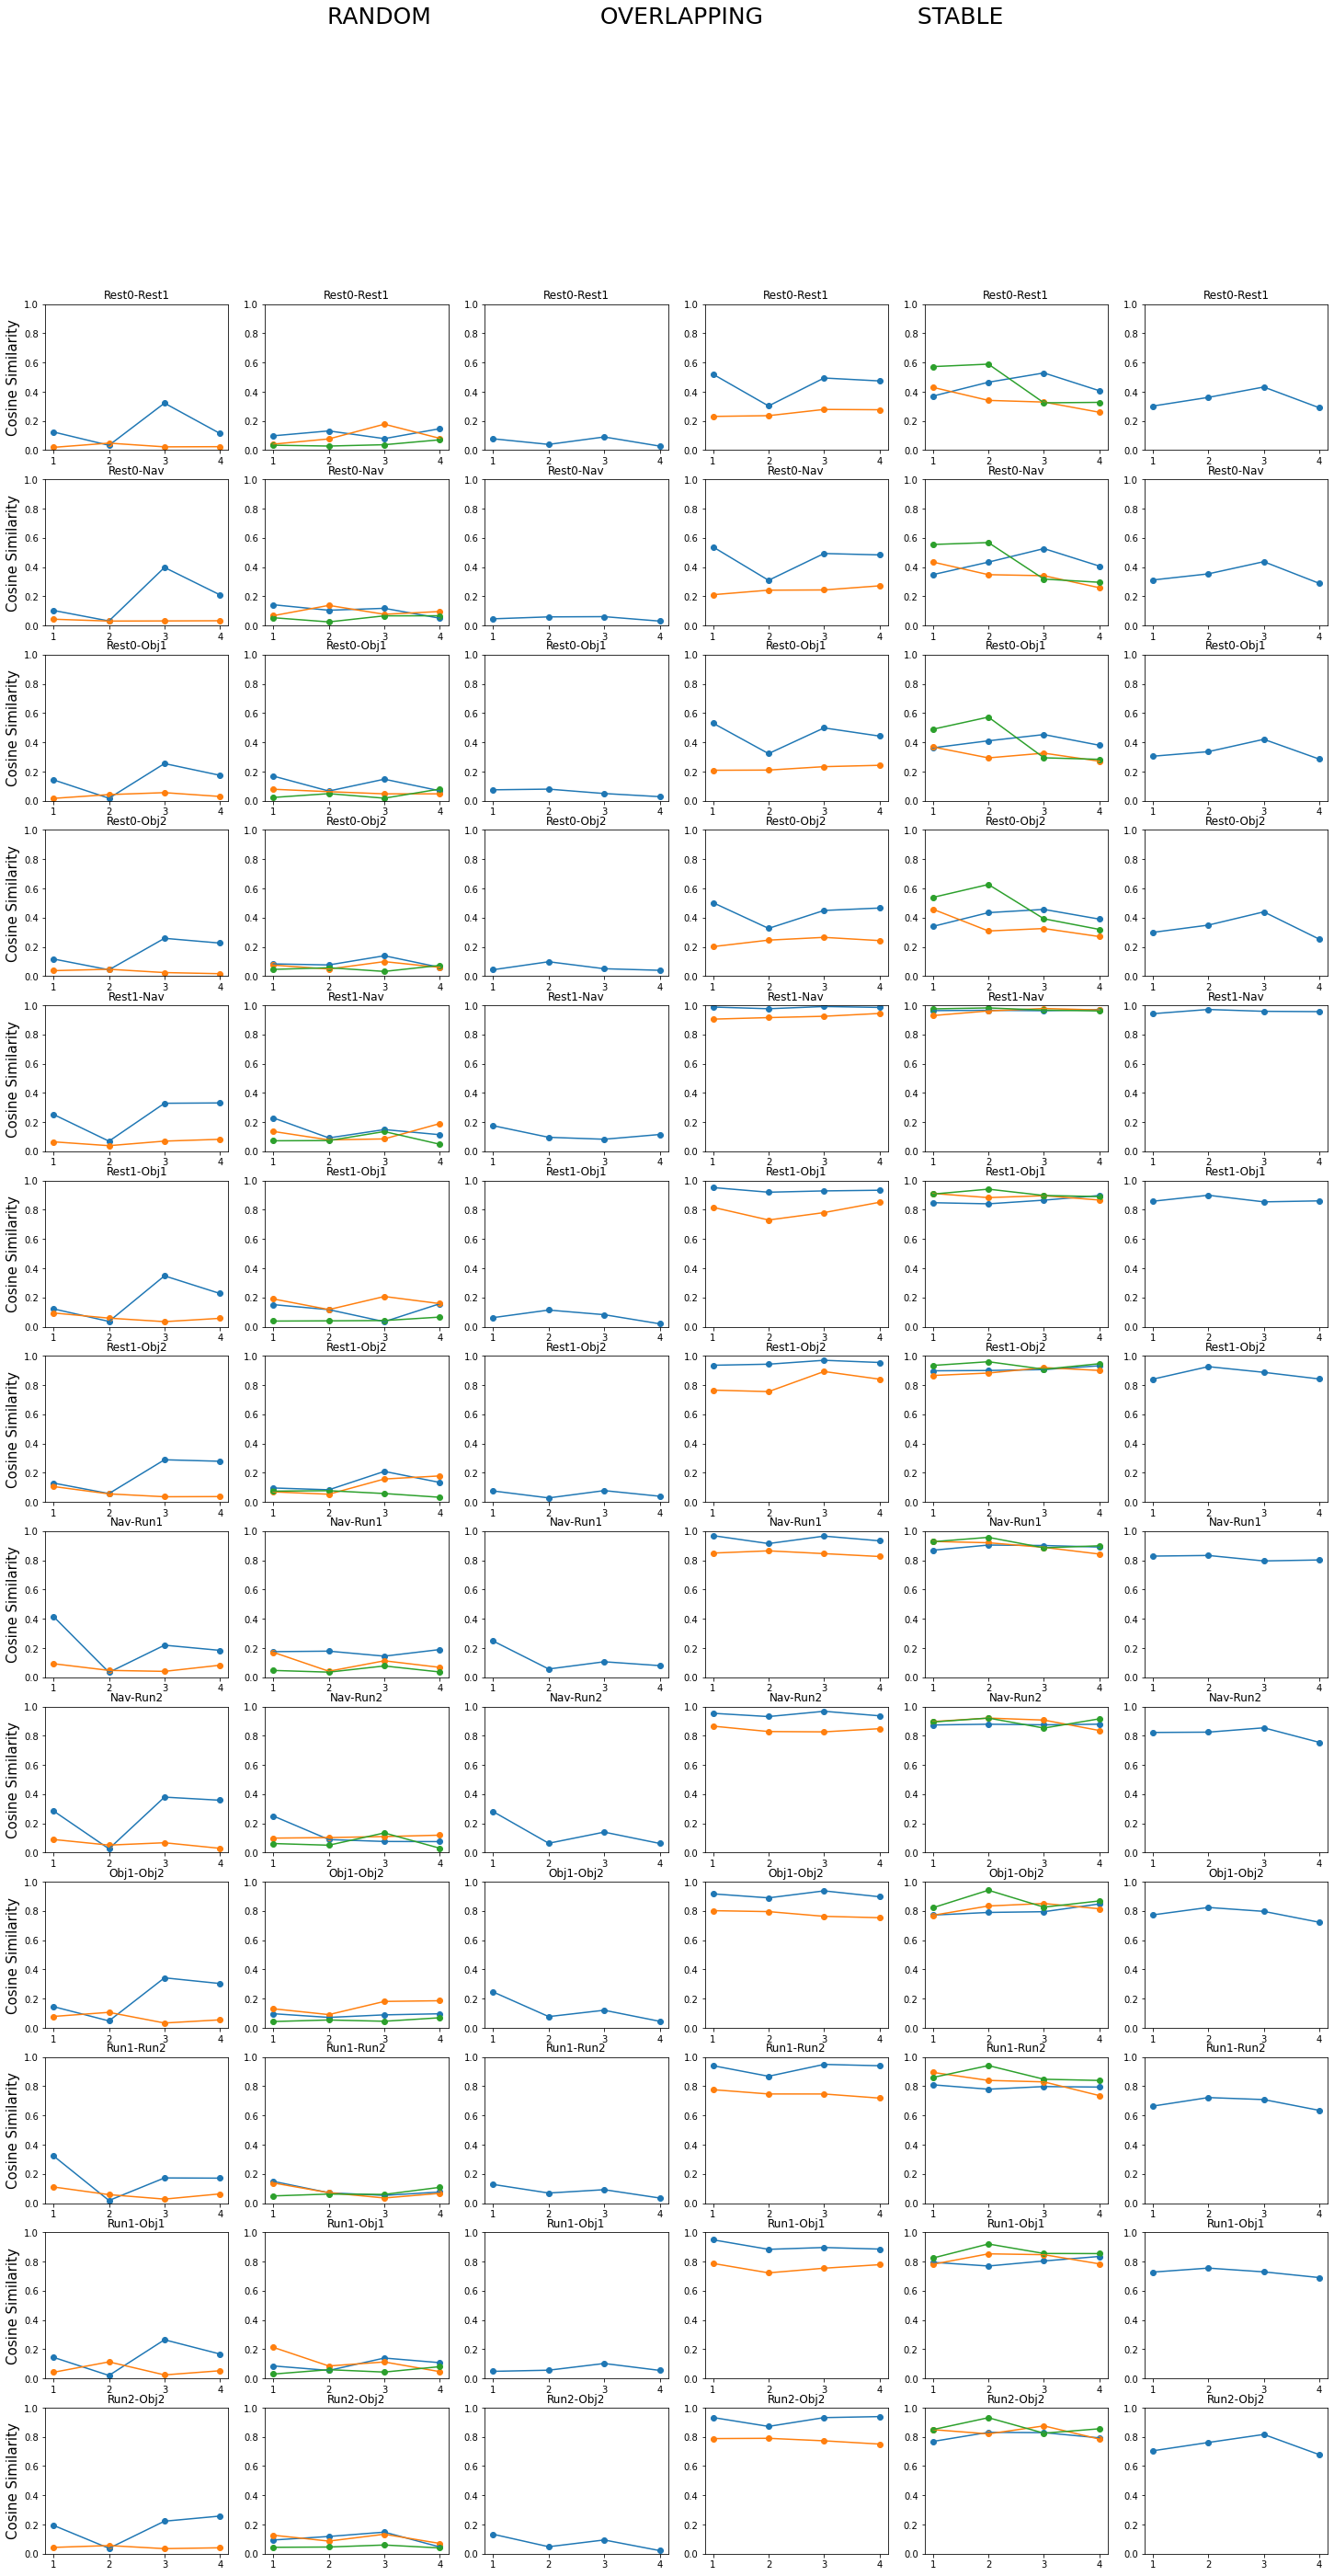

In [14]:
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(13,6)
labels = ['Rest0-Rest1','Rest0-Nav','Rest0-Obj1','Rest0-Obj2',
          'Rest1-Nav','Rest1-Obj1','Rest1-Obj2','Nav-Run1', 'Nav-Run2','Obj1-Obj2',
          'Run1-Run2','Run1-Obj1','Run2-Obj2']

condition_list = []
condition_list2 = []

for condition in range(3):
    condition_array = np.zeros((len(evolution_signal[condition])*13,4))
    condition_array2 = np.zeros((len(evolution_signal[condition])*13,4))

    for mouse in range(len(evolution_signal[condition])):     
        for i in range(13):
            axes[i,condition].set_title(labels[i])
            axes[i,condition].scatter([1,2,3,4],evolution_signal[condition][mouse][:,i])
            axes[i,condition].plot([1,2,3,4],evolution_signal[condition][mouse][:,i])  
            
            axes[i,condition+3].set_title(labels[i])
            axes[i,condition+3].scatter([1,2,3,4],evolution_noise[condition][mouse][:,i])
            axes[i,condition+3].plot([1,2,3,4],evolution_noise[condition][mouse][:,i]) 
            axes[i,condition].set_ylim([0,1])
            axes[i,condition+3].set_ylim([0,1])

            #axes[i,j].legend(labels[i*3+j])
            if condition == 0:
                axes[i,condition].set_ylabel('Cosine Similarity', fontsize = 15)
            #axes[i,condition].set_ylim([0, 0.07])
        condition_array[mouse*13:(mouse+1)*13,:] = evolution_signal[condition][mouse].T
        condition_array2[mouse*13:(mouse+1)*13,:] = evolution_noise[condition][mouse].T

        #axes[i,condition].set_xlabel('Training days', fontsize = 15)
        #x_pos = np.arange(1,5)
        #axes[i,condition].set_xticks(x_pos)
        #axes[i,condition].set_xticklabels(x_axes)
        #plt.setp(axes[i,condition].get_xticklabels(), rotation=45, ha="right",
        #        rotation_mode="anchor")
    condition_list.append(condition_array)
    condition_list2.append(condition_array2)
fig.tight_layout()
fig.set_size_inches(25,45)
fig.suptitle('RANDOM                       OVERLAPPING                     STABLE' , fontsize = 25)
#figure_name = figure_path +'distance_evolution_events_all_mice'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'new.png'

figure_name = figure_path +'cos_sim_evolution_all_mice'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

fig.savefig(figure_name)  

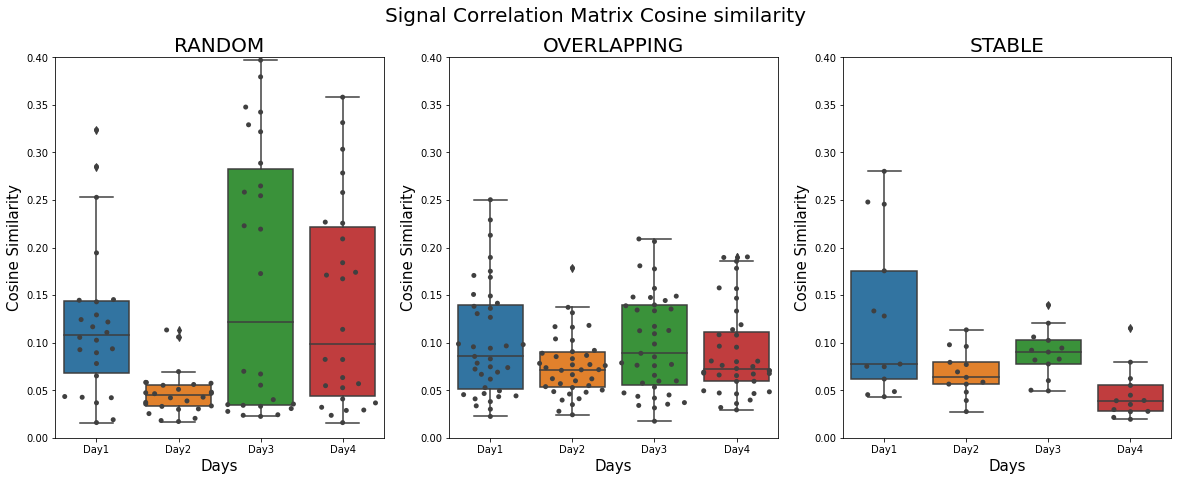

In [17]:
import seaborn as sns
figure = plt.figure()
gs = plt.GridSpec(1, 3)
conditions = ['RANDOM','OVERLAPPING','STABLE']
label = ['Day1', 'Day2','Day3','Day4']

for i in range(3):
    axes= figure.add_subplot(gs[0,i])
    axes = sns.boxplot(data = condition_list[i], orient = 'v')
    axes = sns.swarmplot(data=condition_list[i], color=".25")
    #axes_cca_gnb.bar([])
    axes.set_xticklabels(label)
    axes.set_xlabel('Days', fontsize = 15)
    axes.set_ylabel('Cosine Similarity', fontsize = 15)
    axes.set_title(conditions[i], fontsize = 20)
    axes.set_ylim([0,0.4])

figure.set_size_inches([20, 7])

figure.suptitle('Signal Correlation Matrix Cosine similarity', fontsize = 20)
figure_name = figure_path + 'correlation_matrix_cosine_similarity.png'
figure.savefig(figure_name)


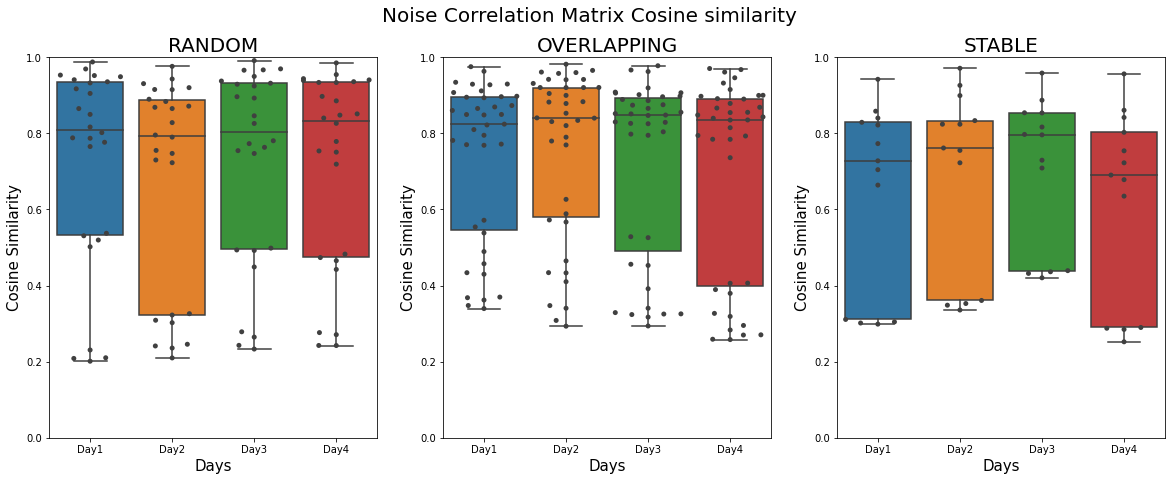

In [18]:
import seaborn as sns
figure = plt.figure()
gs = plt.GridSpec(1, 3)
conditions = ['RANDOM','OVERLAPPING','STABLE']
label = ['Day1', 'Day2','Day3','Day4']

for i in range(3):
    axes= figure.add_subplot(gs[0,i])
    axes = sns.boxplot(data = condition_list2[i], orient = 'v')
    axes = sns.swarmplot(data=condition_list2[i], color=".25")
    #axes_cca_gnb.bar([])
    axes.set_xticklabels(label)
    axes.set_xlabel('Days', fontsize = 15)
    axes.set_ylabel('Cosine Similarity', fontsize = 15)
    axes.set_title(conditions[i], fontsize = 20)
    axes.set_ylim([0,1])

figure.set_size_inches([20, 7])

figure.suptitle('Noise Correlation Matrix Cosine similarity', fontsize = 20)
figure_name = figure_path + 'correlation_matrix_noise_cosine_similarity.png'
figure.savefig(figure_name)